# One Pixel Attack Tutorial
## Part 1 - Cifar10

### Dan Kondratyuk
### September 15, 2019

![](images/pred2.png "All it takes is one pixel")

This notebook will demonstrate the one pixel attack with a few different convolutional neural network models. By using differential evolution, we find a special pixel that can modify a target image such that the network misclassifies the image (which it previously correctly classified).

In theory, we want models that don't get fooled by such tiny changes. Especially in images, it is undesirable to have a small alteration in the input result in a drastic change in the output. However, even the most accurate neural networks are susceptible to this type of attack.

To read more about it, see [the original paper](https://arxiv.org/abs/1710.08864), or the authors' [official repo](https://github.com/Carina02/One-Pixel-Attack).

Let's get started.

## Imports

Ensure that you have `numpy`, `pandas`, `scipy`, `matplotlib`, `tensorflow-gpu`, and `keras` installed.

Alternatively, you may [run this notebook in Google Colab](https://colab.research.google.com/drive/1Zq1kGP9C7i-70-SXyuEEaqYngtyQZMn7). Note: colab allows you to run this notebook on GPU, free of charge. Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [ ]:
# If running in Google Colab, import files
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/Hyperparticle/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
import sys
from keras.datasets import cifar10
from keras import backend as K
from matplotlib import pyplot


from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator



# Custom Networks
from networks.lenet import LeNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 346, done.
remote: Total 346 (delta 0), reused 0 (delta 0), pack-reused 346
Receiving objects: 100% (346/346), 44.43 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (201/201), done.
renamed 'one-pixel-attack-keras/1_one-pixel-attack-cifar10.ipynb' -> './1_one-pixel-attack-cifar10.ipynb'
renamed 'one-pixel-attack-keras/2_one-pixel-attack-imagenet.ipynb' -> './2_one-pixel-attack-imagenet.ipynb'
renamed 'one-pixel-attack-keras/attack.py' -> './attack.py'
renamed 'one-pixel-attack-keras/CONTRIBUTING.md' -> './CONTRIBUTING.md'
renamed 'one-pixel-attack-keras/data' -> './data'
renamed 'one-pixel-attack-keras/differential_evolution.py' -> './differential_evolution.py'
renamed 'one-pixel-attack-keras/helper.py' -> './helper.py'
renamed 'one-pixel-attack-keras/images' -> './images'
renamed 'one-pixel-attack-keras/LICENSE' -> './LICENSE'
renamed 'one-pixel-attack-keras/networks' -> './networks'
renamed 'one-pixel-attack-keras/

## Load Dataset

For this attack, we will use the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) packaged by Keras. The task of the dataset is to correctly classify a 32x32 pixel image in 1 of 10 categories (e.g., bird, deer, truck).

The code below will load the Cifar10 dataset. Keras will need to download the dataset if it is not cached locally already.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

We can access and display any image in the dataset by its index. For instance, here is a horse.

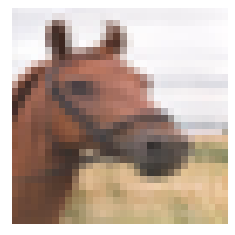

In [ ]:
image_id = 99 # Image index in the test set
helper.plot_image(x_test[image_id])

## Image Perturbation

To begin, we need a function to modify one or more pixels in an image. 

We can define the perturbation of a pixel as a 5-tuple 

$$\textbf{x} = (x, y, r, g, b)$$

where $x, y$ are the coordinates of the pixel from 0 to 31, and $r,g,b$ are the red, green, and blue values from 0 to 255. Then multiple perturbations can simply be a concatenation of these tuples:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

We could instead use an array of tuples, but the optimization algorithm we will use requires it to be a flat 1-d vector.

Then the function to perturb an image can take as an input the image and $X$, and output a copy of the image with each pixel at $x_i, y_i$ modified to have the color $r_i, g_i, b_i$. To speed up computation, we will batch together an array of $X$ perturbations, denoted $X_S$.

In [ ]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

Now we can modify the pixels of any image we want.

Let's modify our horse image by making pixel (16,16) yellow.

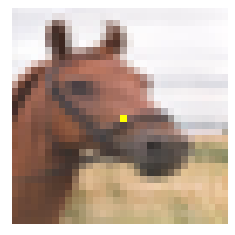

In [ ]:
image_id = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]

helper.plot_image(image_perturbed)

## Load Models

To demonstrate the attack, we need some neural network models trained on the Cifar10 dataset. We will now load some pretrained models, which can be found in the `networks/models` directory.

It is recommended to use Keras with a GPU enabled. If you're [running in Google Colab](https://colab.research.google.com/drive/1Zq1kGP9C7i-70-SXyuEEaqYngtyQZMn7), you can enable a GPU instance by selecting `Runtime > Change runtime type > Hardware accelerator > GPU` (you will need to re-run all cells). The code below can be used to check (if using TensorFlow).

In [ ]:
# Should output /device:GPU:0
# K.tensorflow_backend._get_available_gpus()

There are two models included in this repository, `lenet` and `resnet` which will be loaded from disk automatically.

Optionally, you may [download the larger, more accurate models](https://www.dropbox.com/sh/dvatkpjl0sn79kn/AAC9L4puJ_sdFUkDZfr5SFkLa?dl=0) (e.g., Capsule Network, DenseNet, etc.). Make sure to copy the models into the `networks/models/` directory. Then uncomment the lines below and run the cell to load the models of your choosing.

In [ ]:
lenet = LeNet()
resnet = ResNet()

models = [lenet, resnet]

## Uncomment below to load more models to play with. Make sure the model files exist by training or downloading them.

# lenet = LeNet()
# pure_cnn = PureCnn()
# net_in_net = NetworkInNetwork()
# resnet = ResNet()
# densenet = DenseNet()
# wide_resnet = WideResNet()
# capsnet = CapsNet()

# models = [lenet, pure_cnn, net_in_net, resnet, densenet, wide_resnet, capsnet]

Successfully loaded lenet
Successfully loaded resnet


Note that there are even more networks available in the `networks` directory, but must be trained before loading them here.

### Calculate Model Accuracies

After loading the models, we would like to evaluate all test images with each model to ensure that we only attack the images which have been classified correctly. The code below will also display the accuracy and number of parameters of each model.

In [ ]:
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating lenet
Evaluating resnet


name  accuracy  param_count
0   lenet    0.7488        62006
1  resnet    0.9231       470218

### Prediction Function

For the black-box attack, all we should care about is the inputs to the model (the images), and the outputs of the model (the prediction probabilities). No special information about the model is required; we could even swap it with a model that is not a neural network.

Define a function that runs several perturbed images on a given model and returns the model's confidence (probability output) in the target class, one confidence value per image. If the target class is the correct class, this will be the function that we want to minimize so that the model will be most confident in another class (which is incorrect). Otherwise, the target is an incorrect class and we will want to maximize it.

In [ ]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

Below we can modify a pixel in an image and see how the confidence of the model changes. In almost all cases, the confidence will not change. However, for very special cases it will change drastically.

Confidence in true class bird is 0.00018887517
Prior confidence was 0.7066177


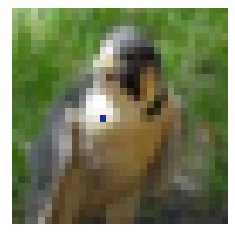

In [ ]:
image_id = 384
pixel = np.array([16, 13,  25, 48, 156])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

## The Attack

Here we will demonstrate two variants of the one pixel attack: untargeted and targeted.

### Targeted vs. Untargeted Attacks

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to perturb an image as to minimize the confidence probability of the correct classification category and maximize the sum of the probabilities of all other categories.

The objective of a targeted attack is to cause a model to classify an image as a given  target class. We want to perturb an image as to maximize the probability of a class of our own choosing.

### Success Criterion

Define a function so that whenever a given perturbation is sufficient to fool a model, it returns `True`. This will be called the success criterion. The `targeted_attack` boolean flag will indicate whether success means maximization of the target class or minimization of the correct (target) class.

In [ ]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

Here we demonstrate the usage of the success criterion function. It's nearly identical to `predict_class()` as before, but also decides the success of the attack. For purposes of demonstration we assume an untargeted attack.

Confidence: 0.07460091
Prior confidence 0.50054234
Attack success: True


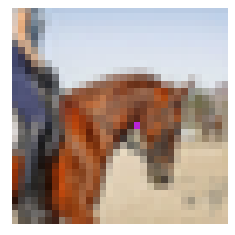

In [ ]:
image_id = 541
pixel = np.array([17, 18, 185, 36, 215])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
success = attack_success(pixel, x_test[image_id], true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

### Attack Function

Finally, we arrive at the attack itself: how do we find the pixels that will result in a successful attack? First, formulate it as an optimization problem: in an untargeted attack, minimize the confidence of the correct class, and in a targeted attack, maximize the confidence of a target class. This is precisely our `predict_class` function.

When performing black-box optimizations such as the one pixel attack, it can be very difficult to find an efficient gradient-based optimization that will work for the problem. It would be nice to use an optimization algorithm that can find good solutions without relying on the smoothness of the function. In our case, we have discrete integer positions ranging from 0 to 31 and color intensities from 0 to 255, so the function is expected to be jagged.

For that, we use an algorithm called [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution). Here's an example of differential evolution optimizing the [Ackley function](https://en.wikipedia.org/wiki/Ackley_function) (if you're using Google Colab, run the code cell below):

<br>

![Ackley GIF](images/Ackley.gif)

<br>

Differential evolution is a type of evolutionary algorithm where a population of candidate solutions generate offspring which compete with the rest of the population each generation according to their fitness. Each candidate solution is represented by a vector of real numbers which are the inputs to the function we would like to minimize. The lower the output of this function, the better the fitness. The algorithm works by initializing a (usually random) population of vectors, generating new offspring vectors by combining (mutating) individuals in the population, and replacing worse-performing individuals with better candidates.

In the context of the one pixel attack, our input will be a flat vector of pixel values:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

These will be encoded as floating-point values, but will be floored back into integers to calculate image perturbations. First we generate a random population of $n$ perturbations

$$\textbf{P} = (X_1, X_2, \dots, X_n)$$

Then, on each iteration we calculate $n$ new mutant children using the formula

$$X_i = X_{r1} + F (X_{r2} - X_{r3})$$

such that

$$r1 \neq r2 \neq r3$$

where $r1,r2,r3$ are random indices into our population $\textbf{P}$, and $F = 0.5$ is a mutation parameter. Basically, we pick 3 random individuals from the previous generation and recombine them to make a new candidate solution. If this candidate $X_i$ gives a lower minimum at position $i$ (i.e., the attack is closer to success), replace the old $X_i$ with this new one. This process repeats for several iterations until our stopping criterion, `attack_success`, which is when we find an image that successfully completes the attack.

<br>

See [this excellent tutorial post](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/) on how differential evolution works in greater detail. 

We will use a [slight modification](differential_evolution.py) of [Scipy's implementation of differential evolution](https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html) to utilize GPU parallelism by batching predictions together.

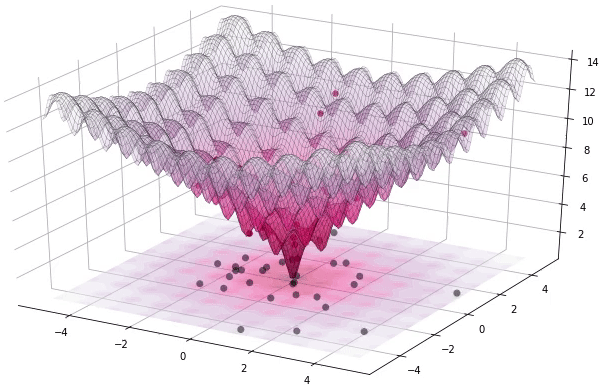

In [ ]:
# Run this cell if you are using Google Colab to see the Ackley GIF
if in_colab:
    from IPython.display import Image
    with open('images/Ackley.gif','rb') as file:
        display(Image(file.read()))

In [ ]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img_id])[0]
    prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not) 
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)
    matplotlib.image.imsave('out.png', attack_image)


    #return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x, attack_image]
    return [attack_image, actual_class, predicted_class]

#### Untargeted Attack

Let's look at one iteration of the untargeted attack. Here we will demonstrate a successful attack an image of a frog with the `resnet` model. We should see the confidence in the true class drop after several iterations.

Try to see if you can successfully attack other images/models. The more pixels we are allowed to modify, the more likely it is we are to find a solution for any given image.

Confidence: 0.79889786
Confidence: 0.79889786
Confidence: 0.79889786
Confidence: 0.79889786
Confidence: 0.5983494
Confidence: 0.5983494
Confidence: 0.5138316
Confidence: 0.5138316
Confidence: 0.5138316
Confidence: 0.5138316
Confidence: 0.41657847


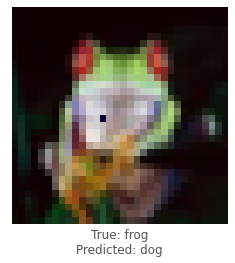

Confidence: 0.9699233
Confidence: 0.9699233
Confidence: 0.9681188
Confidence: 0.9373095
Confidence: 0.9373095
Confidence: 0.9373095
Confidence: 0.9027737
Confidence: 0.9027737
Confidence: 0.9027737
Confidence: 0.9027737
Confidence: 0.90098315
Confidence: 0.88017255
Confidence: 0.86383575
Confidence: 0.86383575
Confidence: 0.8460876
Confidence: 0.83872515
Confidence: 0.83872515
Confidence: 0.83872515
Confidence: 0.7937862
Confidence: 0.78894395
Confidence: 0.78894395
Confidence: 0.7843253
Confidence: 0.78181696
Confidence: 0.7778891
Confidence: 0.7778891
Confidence: 0.7778891
Confidence: 0.7778891
Confidence: 0.7775176
Confidence: 0.7775176
Confidence: 0.7775176
Confidence: 0.7775176
Confidence: 0.7775176
Confidence: 0.7775176
Confidence: 0.7775176
Confidence: 0.7775176
Confidence: 0.7775176
Confidence: 0.7775176
Confidence: 0.7775176
Confidence: 0.7775176
Confidence: 0.7775176
Confidence: 0.77535874
Confidence: 0.7752753
Confidence: 0.7746922
Confidence: 0.7743117
Confidence: 0.7743117

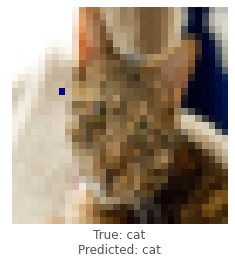

Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence:

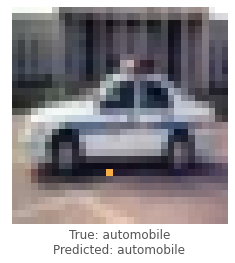

Confidence: 0.998125
Confidence: 0.998125
Confidence: 0.99768317
Confidence: 0.9969187
Confidence: 0.9962837
Confidence: 0.99571484
Confidence: 0.99140114
Confidence: 0.99140114
Confidence: 0.99140114
Confidence: 0.9866947
Confidence: 0.98636836
Confidence: 0.98636836
Confidence: 0.98636836
Confidence: 0.9863559
Confidence: 0.9863559
Confidence: 0.9863559
Confidence: 0.9863559
Confidence: 0.9857853
Confidence: 0.98522735
Confidence: 0.9845791
Confidence: 0.9845791
Confidence: 0.9845791
Confidence: 0.98440415
Confidence: 0.98440415
Confidence: 0.98410416
Confidence: 0.98410416
Confidence: 0.98410416
Confidence: 0.9840147
Confidence: 0.9840147
Confidence: 0.9840147
Confidence: 0.9840147
Confidence: 0.9840147
Confidence: 0.9840147
Confidence: 0.9840147
Confidence: 0.9840147
Confidence: 0.9839246
Confidence: 0.9839246
Confidence: 0.9839246
Confidence: 0.9839246
Confidence: 0.9839246
Confidence: 0.9839246
Confidence: 0.9839246
Confidence: 0.9839246
Confidence: 0.9839246
Confidence: 0.983924

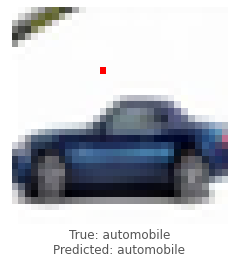

Confidence: 0.99071735
Confidence: 0.99071735
Confidence: 0.95565414
Confidence: 0.37906793


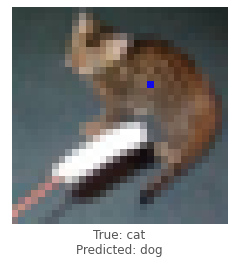

/content/differential_evolution.py:585: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confiden

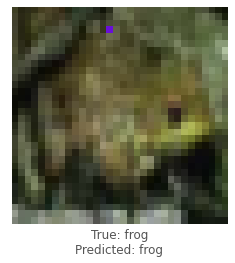

Confidence: 0.60085356
Confidence: 0.60085356
Confidence: 0.60085356
Confidence: 0.59695834
Confidence: 0.5425322
Confidence: 0.5425322
Confidence: 0.4862641


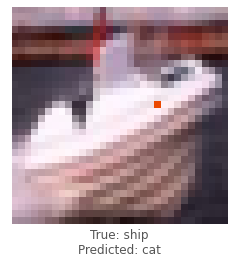

Confidence: 0.40733156


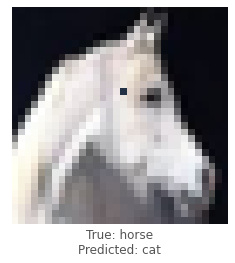

Confidence: 0.8708237
Confidence: 0.59466255
Confidence: 0.4756545


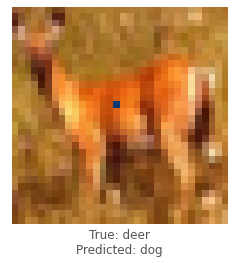

Confidence: 0.9990957
Confidence: 0.9989913
Confidence: 0.9989913
Confidence: 0.99857163
Confidence: 0.99827003
Confidence: 0.99827003
Confidence: 0.99827003
Confidence: 0.9982146
Confidence: 0.9982146
Confidence: 0.9982146
Confidence: 0.9982146
Confidence: 0.9982146
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.998168
Confidence: 0.9981616
Confidence: 0.9981616
Confidence: 0.9981616
Confidence: 0.9981616
Confidence: 0.99815995
Confidence: 0.99815995
Confidence: 0.99815875
Confidence: 0.99815875
Confidence: 0.99815875
Confidence: 0.9981572
Confidence: 0.9981572
Confidence: 0.9981572
Confidence: 0.9981572
Confidence: 0.9981572
Confidence: 0.9981572
Confidence: 0.9981572
Confidence: 0.9981572
Confidence: 0.9981572
Confidence: 0.9981572
Confidence: 0.9

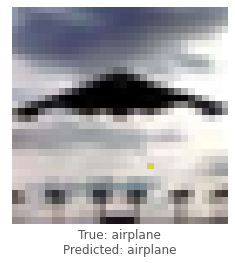

Confidence: 0.0013791635


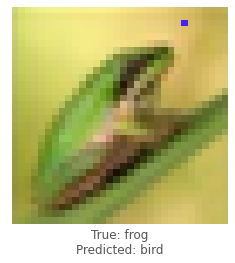

Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999701
Confidence: 0.9999701
Confidence: 0.9999701
Confidence: 0.9999701
Confidence: 0.99990654
Confidence: 0.99990654
Confidence: 0.99987864
Confidence: 0.99987864
Confidence: 0.9998592
Confidence: 0.9998443
Confidence: 0.9998443
Confidence: 0.9998443
Confidence: 0.99982303
Confidence: 0.99982303
Confidence: 0.99982005
Confidence: 0.99982005
Confidence: 0.99982005
Confidence: 0.99981874
Confidence: 0.99981874
Confidence: 0.99981874
Confidence: 0.99981874
Confidence: 0.99981874
Confidence: 0.99981874
Confidence: 0.99981874
Confidence: 0.99981874
Confidence: 0.99981874
Confidence: 0.99981874
Confidence: 0.99981874
Confidence: 0.99981874
Confidence: 0.99981874
Confidence: 0.9998184
Confidence: 0.9998184
Confidence: 0.9998184
Confidence: 0.9998184
Confidence: 0.9998184
Confiden

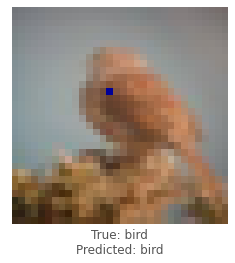

Confidence: 0.9993605
Confidence: 0.9990564
Confidence: 0.9990564
Confidence: 0.9990564
Confidence: 0.9990564
Confidence: 0.99869007
Confidence: 0.99869007
Confidence: 0.9986802
Confidence: 0.9985656
Confidence: 0.9985656
Confidence: 0.9982924
Confidence: 0.9982924
Confidence: 0.9982924
Confidence: 0.9982231
Confidence: 0.9982231
Confidence: 0.9982231
Confidence: 0.9982231
Confidence: 0.9982231
Confidence: 0.9982231
Confidence: 0.9982231
Confidence: 0.9981761
Confidence: 0.9981761
Confidence: 0.9981761
Confidence: 0.9981761
Confidence: 0.99817085
Confidence: 0.99817085
Confidence: 0.99817085
Confidence: 0.99817085
Confidence: 0.9981699
Confidence: 0.9981699
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Confidence: 0.9981687
Conf

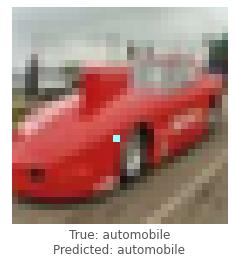

Confidence: 0.7690382
Confidence: 0.74014205
Confidence: 0.7081464
Confidence: 0.7081464
Confidence: 0.7081464
Confidence: 0.63335586
Confidence: 0.6079917
Confidence: 0.6079917
Confidence: 0.57275254
Confidence: 0.57275254
Confidence: 0.57038885
Confidence: 0.5700181
Confidence: 0.5700181
Confidence: 0.5700181
Confidence: 0.5700181
Confidence: 0.56693137
Confidence: 0.56693137
Confidence: 0.56693137
Confidence: 0.56427795
Confidence: 0.5641701
Confidence: 0.5634415
Confidence: 0.5634415
Confidence: 0.5627316
Confidence: 0.5627316
Confidence: 0.5620734
Confidence: 0.5620734
Confidence: 0.5620734
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
Confidence: 0.5613935
C

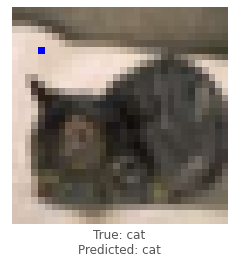

Confidence: 0.99275607
Confidence: 0.99275607
Confidence: 0.99275607
Confidence: 0.9892573
Confidence: 0.9892573
Confidence: 0.9892573
Confidence: 0.9892573
Confidence: 0.9892573
Confidence: 0.98924726
Confidence: 0.98797953
Confidence: 0.9868587
Confidence: 0.9859367
Confidence: 0.98501724
Confidence: 0.98501724
Confidence: 0.98501724
Confidence: 0.98501724
Confidence: 0.98501724
Confidence: 0.98501724
Confidence: 0.98501724
Confidence: 0.98501724
Confidence: 0.98501724
Confidence: 0.9848481
Confidence: 0.9847579
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846688
Confidence: 0.9846

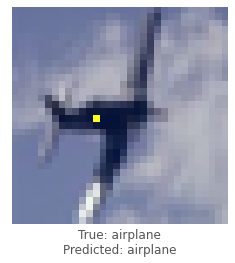

Confidence: 0.84612334
Confidence: 0.84612334
Confidence: 0.84612334
Confidence: 0.84612334
Confidence: 0.84612334
Confidence: 0.84612334
Confidence: 0.84612334
Confidence: 0.8024924
Confidence: 0.8024924
Confidence: 0.8024924
Confidence: 0.8024924
Confidence: 0.79837376
Confidence: 0.79837376
Confidence: 0.79837376
Confidence: 0.79837376
Confidence: 0.79837376
Confidence: 0.7961658
Confidence: 0.7819152
Confidence: 0.75256413
Confidence: 0.75256413
Confidence: 0.75210404
Confidence: 0.7486459
Confidence: 0.7486459
Confidence: 0.7486459
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.7478423
Confidence: 0.747

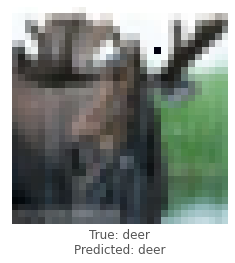

Confidence: 0.00019352311


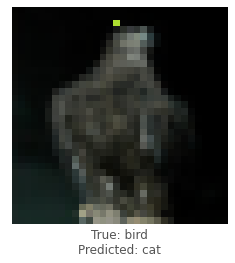

Confidence: 0.9999887
Confidence: 0.9996791
Confidence: 0.9996791
Confidence: 0.9996791
Confidence: 0.9996791
Confidence: 0.9996791
Confidence: 0.9996791
Confidence: 0.99476767
Confidence: 0.99476767
Confidence: 0.99476767
Confidence: 0.99476767
Confidence: 0.9096173
Confidence: 0.9096173
Confidence: 0.9096173
Confidence: 0.9002134
Confidence: 0.7393241
Confidence: 0.7393241
Confidence: 0.7393241
Confidence: 0.7393241
Confidence: 0.7393241
Confidence: 0.7393241
Confidence: 0.7393241
Confidence: 0.7393241
Confidence: 0.6258334
Confidence: 0.6258334
Confidence: 0.6258334
Confidence: 0.6258334
Confidence: 0.6258334
Confidence: 0.61286193
Confidence: 0.61286193
Confidence: 0.61286193
Confidence: 0.61286193
Confidence: 0.55949396
Confidence: 0.55949396
Confidence: 0.55949396
Confidence: 0.55495626
Confidence: 0.55495626
Confidence: 0.54958344
Confidence: 0.5317499
Confidence: 0.5300405
Confidence: 0.5300405
Confidence: 0.5300405
Confidence: 0.5300405
Confidence: 0.5300405
Confidence: 0.5300

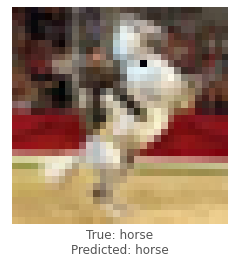

Confidence: 0.99297065
Confidence: 0.9754396
Confidence: 0.9754396
Confidence: 0.8415044
Confidence: 0.6828848
Confidence: 0.6212161
Confidence: 0.58929235
Confidence: 0.58929235
Confidence: 0.58929235
Confidence: 0.52729124
Confidence: 0.52729124
Confidence: 0.52729124
Confidence: 0.52729124
Confidence: 0.50832903
Confidence: 0.49947214


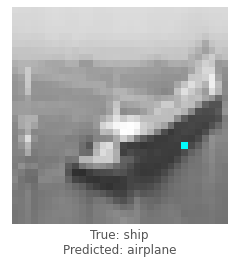

Confidence: 0.9880872
Confidence: 0.9765138
Confidence: 0.9646994
Confidence: 0.9646994
Confidence: 0.9646994
Confidence: 0.9646994
Confidence: 0.9646994
Confidence: 0.9646994
Confidence: 0.9493778
Confidence: 0.9493778
Confidence: 0.94920987
Confidence: 0.94777524
Confidence: 0.9469666
Confidence: 0.9469666
Confidence: 0.94624066
Confidence: 0.9456675
Confidence: 0.9456205
Confidence: 0.9456205
Confidence: 0.9456205
Confidence: 0.9456205
Confidence: 0.94546086
Confidence: 0.94538224
Confidence: 0.94538224
Confidence: 0.94535667
Confidence: 0.94535667
Confidence: 0.94535667
Confidence: 0.94535667
Confidence: 0.94535667
Confidence: 0.94518954
Confidence: 0.94518954
Confidence: 0.9451891
Confidence: 0.9451891
Confidence: 0.9451891
Confidence: 0.9451891
Confidence: 0.9451891
Confidence: 0.9451891
Confidence: 0.94518197
Confidence: 0.94518197
Confidence: 0.94518197
Confidence: 0.94518197
Confidence: 0.94518197
Confidence: 0.94518197
Confidence: 0.94518197
Confidence: 0.94518197
Confidence:

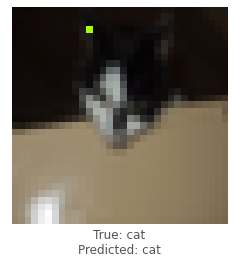

Confidence: 0.9999944
Confidence: 0.9999944
Confidence: 0.9999944
Confidence: 0.9999931
Confidence: 0.9999931
Confidence: 0.9999931
Confidence: 0.9999931
Confidence: 0.9999931
Confidence: 0.99999297
Confidence: 0.99999297
Confidence: 0.9999926
Confidence: 0.9999926
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confiden

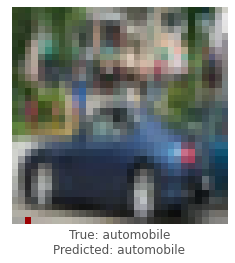

Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999857
Confidence: 0.99999857
Confidence: 0.9999962
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999949
Confidence: 0.9999938
Confidence: 0.9999938
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.99998903
Confidence: 0.99998903
Confidence: 0.99998903
Confidence: 0.9999865
Confidence: 0.9999865
Confidence: 0.9999865
Confidence: 0.9999865
Confidence: 0.9999865
Confidence: 0.9999865
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.

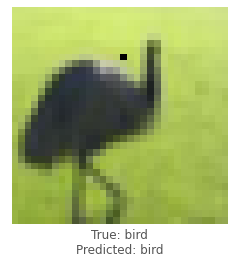

Confidence: 0.9983077
Confidence: 0.9881142
Confidence: 0.96754676
Confidence: 0.96754676
Confidence: 0.96754676
Confidence: 0.96754676
Confidence: 0.9634672
Confidence: 0.9597685
Confidence: 0.959062
Confidence: 0.959062
Confidence: 0.9590325
Confidence: 0.95370144
Confidence: 0.95370144
Confidence: 0.95370144
Confidence: 0.95370144
Confidence: 0.95370144
Confidence: 0.9533304
Confidence: 0.9533304
Confidence: 0.9533304
Confidence: 0.9531544
Confidence: 0.9510553
Confidence: 0.9506847
Confidence: 0.9506847
Confidence: 0.9506847
Confidence: 0.9505493
Confidence: 0.9505493
Confidence: 0.950036
Confidence: 0.950036
Confidence: 0.95002556
Confidence: 0.95002556
Confidence: 0.95002556
Confidence: 0.9499708
Confidence: 0.9439637
Confidence: 0.90780926
Confidence: 0.8988306
Confidence: 0.8951283
Confidence: 0.8951283
Confidence: 0.8951283
Confidence: 0.8951283
Confidence: 0.8951283
Confidence: 0.8951283
Confidence: 0.8951283
Confidence: 0.8951283
Confidence: 0.8951283
Confidence: 0.8951283
C

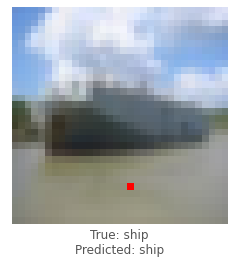

Confidence: 0.031580217


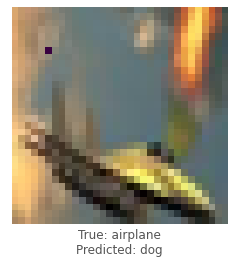

Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99997675
Confidence: 0.9999713
Confidence: 0.9999527
Confidence: 0.9999527
Confidence: 0.9999527
Confidence: 0.9999527
Confidence: 0.9999527
Confidence: 0.9999527
Confidence: 0.99993813
Confidence: 0.99993813
Confidence: 0.9999379
Confidence: 0.9999379
Confidence: 0.9999367
Confidence: 0.9999367
Confidence: 0.9999367
Confidence: 0.99993503
Confidence: 0.99993503
Confidence: 0.99993503
Confidence: 0.99993503
Confidence: 0.9999349
Confidence: 0.9999347
Confidence: 0.9999331
Confidence: 0.9999331
Confidence: 0.9999331
Confidence: 0.9999331
Confidence: 0.9999331
Confidence: 0.9999331
Confidence: 0.9999331
Confidence: 0.9999331
Confidence: 0.9999324
Confidence: 0.9999324
Confidence: 0.9999324
Confidence: 0.9999324
Confidence: 0.9999324
Confidence: 0.9999324
Confidence: 0.99993205
Confidence: 0.99993205
Confidence: 0.9999318
Confidence: 0.9999318
Confidence: 0.9999318
Confidence: 0.9999318
Confidence: 0.9999318
Confidence: 0.9999318

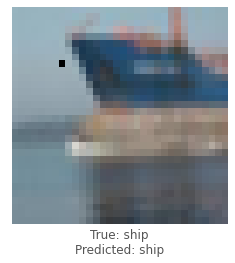

Confidence: 1.9395975e-06


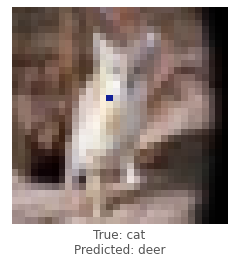

Confidence: 2.7878116e-08


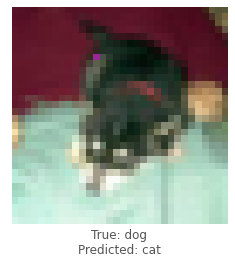

Confidence: 0.9991147
Confidence: 0.9986242
Confidence: 0.99631774
Confidence: 0.98822266
Confidence: 0.98822266
Confidence: 0.98822266
Confidence: 0.9732237
Confidence: 0.9732237
Confidence: 0.9732237
Confidence: 0.9732237
Confidence: 0.9732237
Confidence: 0.9732237
Confidence: 0.9732237
Confidence: 0.9732237
Confidence: 0.9732237
Confidence: 0.9732237
Confidence: 0.9732237
Confidence: 0.9727657
Confidence: 0.9727657
Confidence: 0.9727657
Confidence: 0.9727657
Confidence: 0.9727657
Confidence: 0.9727657
Confidence: 0.9727657
Confidence: 0.9727657
Confidence: 0.9725887
Confidence: 0.9725887
Confidence: 0.9725887
Confidence: 0.9725887
Confidence: 0.972516
Confidence: 0.972516
Confidence: 0.972516
Confidence: 0.972516
Confidence: 0.972516
Confidence: 0.972516
Confidence: 0.972516
Confidence: 0.972516
Confidence: 0.972516
Confidence: 0.972516
Confidence: 0.972516
Confidence: 0.9725056
Confidence: 0.97247195
Confidence: 0.97247195
Confidence: 0.97247195
Confidence: 0.97247195
Confidence: 0

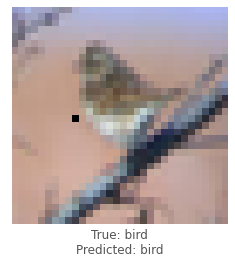

Confidence: 0.9996165
Confidence: 0.990615
Confidence: 0.990615
Confidence: 0.9886107
Confidence: 0.9886107
Confidence: 0.9886107
Confidence: 0.9884207
Confidence: 0.98451877
Confidence: 0.98451877
Confidence: 0.98451877
Confidence: 0.98451877
Confidence: 0.98451877
Confidence: 0.98451877
Confidence: 0.98451877
Confidence: 0.98451877
Confidence: 0.9837578
Confidence: 0.9837578
Confidence: 0.9837578
Confidence: 0.9837578
Confidence: 0.9837578
Confidence: 0.9837578
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Confidence: 0.9817436
Conf

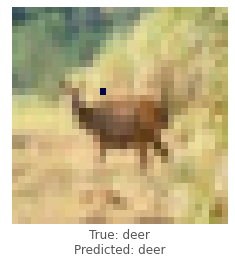

Confidence: 0.9999999
Confidence: 0.9999999
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0

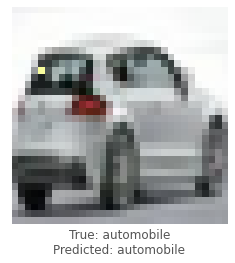

Confidence: 0.99998844
Confidence: 0.9999119
Confidence: 0.9999119
Confidence: 0.9999119
Confidence: 0.9999119
Confidence: 0.9999119
Confidence: 0.9999119
Confidence: 0.9999119
Confidence: 0.9998455
Confidence: 0.9998455
Confidence: 0.9998455
Confidence: 0.9998455
Confidence: 0.9998455
Confidence: 0.9998455
Confidence: 0.9998455
Confidence: 0.9998455
Confidence: 0.9998455
Confidence: 0.9998455
Confidence: 0.9998455
Confidence: 0.9998455
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.99983406
Confidence: 0.9998332
Confidence: 0.9998324
Confidence: 0.99983025
Confidence: 0.99983025
Confidence: 0.99983025
Confidence: 0.99983025
Confidenc

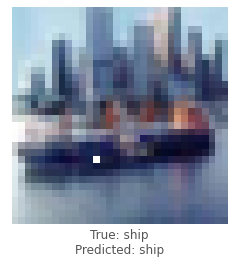

Confidence: 0.99998486
Confidence: 0.99998486
Confidence: 0.99998367
Confidence: 0.99998367
Confidence: 0.99998367
Confidence: 0.99997973
Confidence: 0.999979
Confidence: 0.9999776
Confidence: 0.9999776
Confidence: 0.9999776
Confidence: 0.9999776
Confidence: 0.9999776
Confidence: 0.99997735
Confidence: 0.99997556
Confidence: 0.99997556
Confidence: 0.99997556
Confidence: 0.99997556
Confidence: 0.99997556
Confidence: 0.99997556
Confidence: 0.99997556
Confidence: 0.99997544
Confidence: 0.99997544
Confidence: 0.9999753
Confidence: 0.9999753
Confidence: 0.9999753
Confidence: 0.9999753
Confidence: 0.9999752
Confidence: 0.9999752
Confidence: 0.9999752
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.999

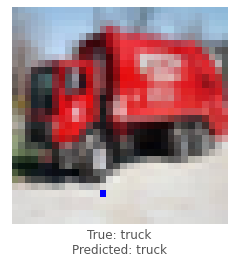

Confidence: 0.671913
Confidence: 0.671913
Confidence: 0.671913
Confidence: 0.64214563
Confidence: 0.64214563
Confidence: 0.64214563
Confidence: 0.64214563
Confidence: 0.64214563
Confidence: 0.64214563
Confidence: 0.6174132
Confidence: 0.6174132
Confidence: 0.6174132
Confidence: 0.6174132
Confidence: 0.6174132
Confidence: 0.6141088
Confidence: 0.6141088
Confidence: 0.6141088
Confidence: 0.609913
Confidence: 0.60871416
Confidence: 0.60871416
Confidence: 0.60871416
Confidence: 0.60871416
Confidence: 0.60774505
Confidence: 0.6074045
Confidence: 0.6074045
Confidence: 0.606991
Confidence: 0.606991
Confidence: 0.60661817
Confidence: 0.60657454
Confidence: 0.60657454
Confidence: 0.6064594
Confidence: 0.6064594
Confidence: 0.60644776
Confidence: 0.60644776
Confidence: 0.60644776
Confidence: 0.60644776
Confidence: 0.60644776
Confidence: 0.60644776
Confidence: 0.60644776
Confidence: 0.60644776
Confidence: 0.60644776
Confidence: 0.60644776
Confidence: 0.60644776
Confidence: 0.60644776
Confidence: 

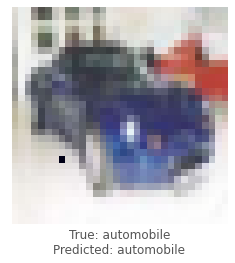

Confidence: 0.9998565
Confidence: 0.9998565
Confidence: 0.9998565
Confidence: 0.9998565
Confidence: 0.9997875
Confidence: 0.9997875
Confidence: 0.9997875
Confidence: 0.9997875
Confidence: 0.9987997
Confidence: 0.9987997
Confidence: 0.9987997
Confidence: 0.9987997
Confidence: 0.9987997
Confidence: 0.9981805
Confidence: 0.9979632
Confidence: 0.9979632
Confidence: 0.9979632
Confidence: 0.9976497
Confidence: 0.9976497
Confidence: 0.9976497
Confidence: 0.9975407
Confidence: 0.9975407
Confidence: 0.9975407
Confidence: 0.9974022
Confidence: 0.9974022
Confidence: 0.9974022
Confidence: 0.9974022
Confidence: 0.9974022
Confidence: 0.9973894
Confidence: 0.9973894
Confidence: 0.9973894
Confidence: 0.997387
Confidence: 0.9973833
Confidence: 0.9973833
Confidence: 0.9973833
Confidence: 0.9973833
Confidence: 0.99737334
Confidence: 0.99737334
Confidence: 0.99737334
Confidence: 0.99737334
Confidence: 0.99737334
Confidence: 0.9973693
Confidence: 0.9973693
Confidence: 0.9973693
Confidence: 0.9973693
Confid

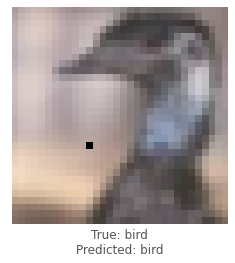

Confidence: 0.9999846
Confidence: 0.9999846
Confidence: 0.9999846
Confidence: 0.9999846
Confidence: 0.9999846
Confidence: 0.999979
Confidence: 0.999979
Confidence: 0.99997866
Confidence: 0.99997866
Confidence: 0.9999776
Confidence: 0.9999571
Confidence: 0.9999492
Confidence: 0.9999492
Confidence: 0.99994123
Confidence: 0.99994123
Confidence: 0.99994123
Confidence: 0.99994123
Confidence: 0.99994123
Confidence: 0.99994123
Confidence: 0.99994123
Confidence: 0.9999393
Confidence: 0.99993575
Confidence: 0.99993575
Confidence: 0.9999356
Confidence: 0.9999355
Confidence: 0.99993455
Confidence: 0.99993455
Confidence: 0.9999341
Confidence: 0.9999341
Confidence: 0.9999341
Confidence: 0.9999341
Confidence: 0.9999335
Confidence: 0.9999335
Confidence: 0.9999305
Confidence: 0.9999305
Confidence: 0.9999305
Confidence: 0.99993026
Confidence: 0.99993026
Confidence: 0.99993026
Confidence: 0.99993026
Confidence: 0.99993026
Confidence: 0.99993026
Confidence: 0.99993026
Confidence: 0.99993026
Confidence: 0

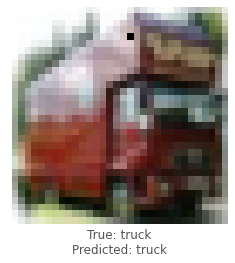

Confidence: 0.9977246
Confidence: 0.99286604
Confidence: 0.99286604
Confidence: 0.99286604
Confidence: 0.99286604
Confidence: 0.99286604
Confidence: 0.97691023
Confidence: 0.97691023
Confidence: 0.97691023
Confidence: 0.97691023
Confidence: 0.97691023
Confidence: 0.97691023
Confidence: 0.97691023
Confidence: 0.97691023
Confidence: 0.97582656
Confidence: 0.97582656
Confidence: 0.9756225
Confidence: 0.9756225
Confidence: 0.9756225
Confidence: 0.9739992
Confidence: 0.9739129
Confidence: 0.9716699
Confidence: 0.97132665
Confidence: 0.97132665
Confidence: 0.97132665
Confidence: 0.97132665
Confidence: 0.97132665
Confidence: 0.97132665
Confidence: 0.97132665
Confidence: 0.97132665
Confidence: 0.97132665
Confidence: 0.97132665
Confidence: 0.97132665
Confidence: 0.97132665
Confidence: 0.9711575
Confidence: 0.9711575
Confidence: 0.9711575
Confidence: 0.9708383
Confidence: 0.9708383
Confidence: 0.9708383
Confidence: 0.9708383
Confidence: 0.9708383
Confidence: 0.9708383
Confidence: 0.9708383
Confi

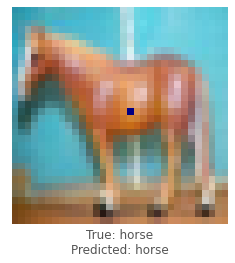

Confidence: 0.88087356
Confidence: 0.47750765


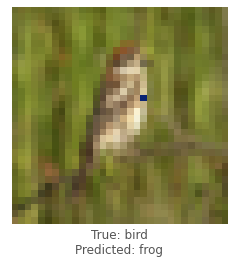

Confidence: 0.12164443


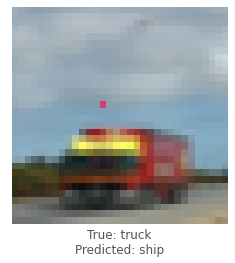

Confidence: 0.98025805
Confidence: 0.98025805
Confidence: 0.97737896
Confidence: 0.97737896
Confidence: 0.97737896
Confidence: 0.97737896
Confidence: 0.97737896
Confidence: 0.97737896
Confidence: 0.97737896
Confidence: 0.97737896
Confidence: 0.97737896
Confidence: 0.97737896
Confidence: 0.97737896
Confidence: 0.97737896
Confidence: 0.97737896
Confidence: 0.97659326
Confidence: 0.9720373
Confidence: 0.9720373
Confidence: 0.9720373
Confidence: 0.9666195
Confidence: 0.9666195
Confidence: 0.9666195
Confidence: 0.9666195
Confidence: 0.9666195
Confidence: 0.9666195
Confidence: 0.96447045
Confidence: 0.9567055
Confidence: 0.9517962
Confidence: 0.9517962
Confidence: 0.9517962
Confidence: 0.9517962
Confidence: 0.9517962
Confidence: 0.9517962
Confidence: 0.9514282
Confidence: 0.9514282
Confidence: 0.9514282
Confidence: 0.9514282
Confidence: 0.9514282
Confidence: 0.9514282
Confidence: 0.9514282
Confidence: 0.95009553
Confidence: 0.95009553
Confidence: 0.95009553
Confidence: 0.95009553
Confidence:

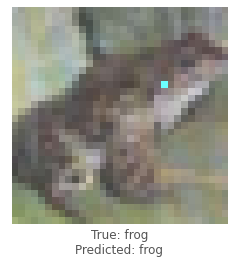

Confidence: 0.9999981
Confidence: 0.99999607
Confidence: 0.99999607
Confidence: 0.99999607
Confidence: 0.99999607
Confidence: 0.99999607
Confidence: 0.9999945
Confidence: 0.9999932
Confidence: 0.9999932
Confidence: 0.9999932
Confidence: 0.9999932
Confidence: 0.9999932
Confidence: 0.9999927
Confidence: 0.9999927
Confidence: 0.9999924
Confidence: 0.9999919
Confidence: 0.9999918
Confidence: 0.9999918
Confidence: 0.9999913
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.99999106
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Conf

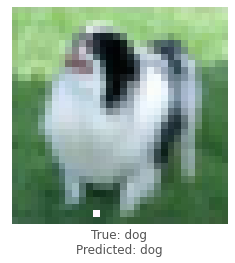

Confidence: 0.9998913
Confidence: 0.9998913
Confidence: 0.9998759
Confidence: 0.9996526
Confidence: 0.9996526
Confidence: 0.999642
Confidence: 0.999642
Confidence: 0.9995734
Confidence: 0.99953854
Confidence: 0.99953854
Confidence: 0.9995359
Confidence: 0.9995359
Confidence: 0.9995359
Confidence: 0.9995359
Confidence: 0.99952877
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995067
Confidence: 0.9995003
Confidence: 0.9995003
Confidence: 0.9995003
Confidence: 0.9995003
Confidence: 0.9995003
Confidence: 0.9994972
Confidence: 0.9994972
Confidence: 0.9994972
Confidence: 0.9994972
Confidence: 0.9994972
Confidence: 0.9994972
Confidence: 0.9994972
Confidence: 0.9994972
Confidence: 0.9994972
Confidence: 0.9994972
Confidenc

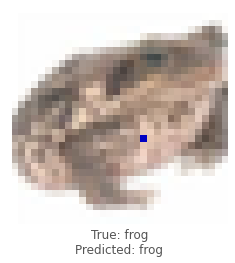

Confidence: 0.00023845307


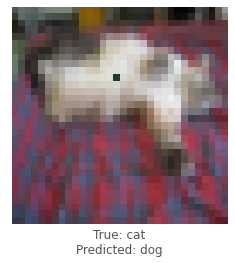

Confidence: 0.99991953
Confidence: 0.99991953
Confidence: 0.99985087
Confidence: 0.99985087
Confidence: 0.9989706
Confidence: 0.99820006
Confidence: 0.99820006
Confidence: 0.997658
Confidence: 0.997658
Confidence: 0.997658
Confidence: 0.997658
Confidence: 0.997658
Confidence: 0.99734455
Confidence: 0.99668
Confidence: 0.99668
Confidence: 0.995076
Confidence: 0.995076
Confidence: 0.99449736
Confidence: 0.99169016
Confidence: 0.9902084
Confidence: 0.9902084
Confidence: 0.9902084
Confidence: 0.9902084
Confidence: 0.9902084
Confidence: 0.9902084
Confidence: 0.9902084
Confidence: 0.9902084
Confidence: 0.9902084
Confidence: 0.98977053
Confidence: 0.9896404
Confidence: 0.9896404
Confidence: 0.9896404
Confidence: 0.9896404
Confidence: 0.9896404
Confidence: 0.9896404
Confidence: 0.9893875
Confidence: 0.9893875
Confidence: 0.9892498
Confidence: 0.9892498
Confidence: 0.9892498
Confidence: 0.9892498
Confidence: 0.98911804
Confidence: 0.98911804
Confidence: 0.98911804
Confidence: 0.98911804
Confide

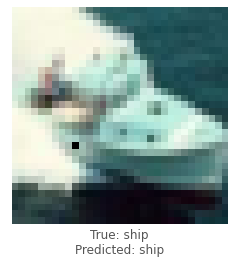

Confidence: 0.23322414


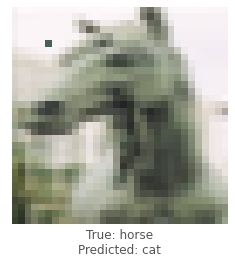

Confidence: 0.9992906
Confidence: 0.99651706
Confidence: 0.99651706
Confidence: 0.99651706
Confidence: 0.99327
Confidence: 0.9929941
Confidence: 0.9929941
Confidence: 0.9787935
Confidence: 0.9787935
Confidence: 0.9787935
Confidence: 0.97028714
Confidence: 0.95701075
Confidence: 0.95701075
Confidence: 0.95701075
Confidence: 0.95701075
Confidence: 0.95701075
Confidence: 0.95701075
Confidence: 0.95701075
Confidence: 0.95701075
Confidence: 0.9548378
Confidence: 0.9548378
Confidence: 0.9548378
Confidence: 0.9548378
Confidence: 0.9548378
Confidence: 0.9548378
Confidence: 0.95403117
Confidence: 0.95403117
Confidence: 0.95403117
Confidence: 0.95403117
Confidence: 0.9535504
Confidence: 0.9535504
Confidence: 0.9535504
Confidence: 0.9535504
Confidence: 0.9535504
Confidence: 0.9534288
Confidence: 0.953408
Confidence: 0.953408
Confidence: 0.953408
Confidence: 0.953408
Confidence: 0.953408
Confidence: 0.953408
Confidence: 0.953408
Confidence: 0.953408
Confidence: 0.953408
Confidence: 0.953408
Confid

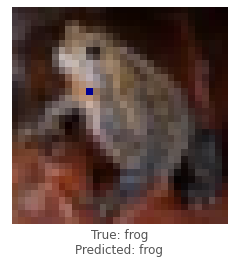

Confidence: 2.4864576e-06


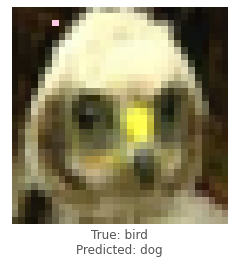

Confidence: 0.087982036


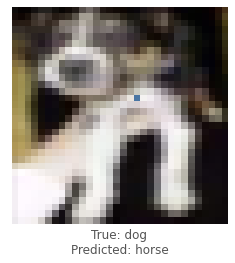

Confidence: 0.99747026
Confidence: 0.99747026
Confidence: 0.99747026
Confidence: 0.99747026
Confidence: 0.99747026
Confidence: 0.99747026
Confidence: 0.99512166
Confidence: 0.9913015
Confidence: 0.9856097
Confidence: 0.9856097
Confidence: 0.9856097
Confidence: 0.9856097
Confidence: 0.9856097
Confidence: 0.9856097
Confidence: 0.9856097
Confidence: 0.9856097
Confidence: 0.98065656
Confidence: 0.98065656
Confidence: 0.9773408
Confidence: 0.9739005
Confidence: 0.9739005
Confidence: 0.9679404
Confidence: 0.9679404
Confidence: 0.96766
Confidence: 0.96766
Confidence: 0.96766
Confidence: 0.96766
Confidence: 0.96766
Confidence: 0.967502
Confidence: 0.967502
Confidence: 0.967502
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.9637582
Confidence: 0.

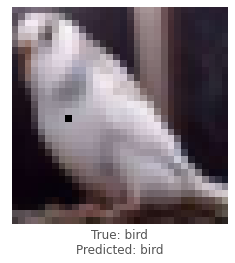

Confidence: 0.89662755
Confidence: 0.89662755
Confidence: 0.8848162
Confidence: 0.8848162
Confidence: 0.84464484
Confidence: 0.84464484
Confidence: 0.84464484
Confidence: 0.8203908
Confidence: 0.7801711
Confidence: 0.6308874
Confidence: 0.4727748


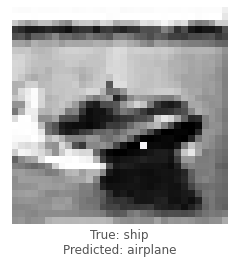

Confidence: 0.12841368


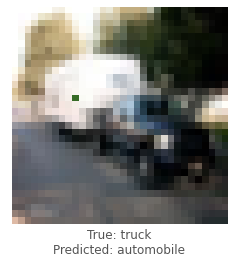

Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999833
Confidence: 0.99999833
Confidence: 0.99999833
Confidence: 0.9999982
Confidence: 0.9999982
Confidence: 0.9999982
Confidence: 0.9999982
Confidence: 0.9999982
Confidence: 0.9999982
Confidence: 0.9999982
Confidence: 0.9999982
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.999997
Confidence: 0.9999912
Confidence: 0.

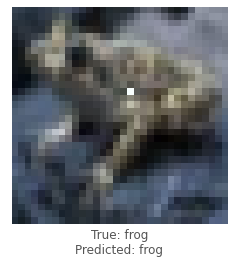

Confidence: 0.99997556
Confidence: 0.999956
Confidence: 0.999956
Confidence: 0.9999497
Confidence: 0.9999497
Confidence: 0.9999497
Confidence: 0.9999497
Confidence: 0.9999497
Confidence: 0.9999497
Confidence: 0.99994826
Confidence: 0.99994826
Confidence: 0.99994826
Confidence: 0.99994683
Confidence: 0.99994683
Confidence: 0.9999466
Confidence: 0.9999379
Confidence: 0.9999379
Confidence: 0.9999317
Confidence: 0.9999317
Confidence: 0.9999317
Confidence: 0.9999317
Confidence: 0.99993145
Confidence: 0.99993145
Confidence: 0.99993145
Confidence: 0.99993145
Confidence: 0.99993145
Confidence: 0.99993145
Confidence: 0.99993145
Confidence: 0.99993145
Confidence: 0.99993145
Confidence: 0.9999305
Confidence: 0.9999305
Confidence: 0.9999305
Confidence: 0.9999305
Confidence: 0.9999305
Confidence: 0.9999305
Confidence: 0.9999299
Confidence: 0.9999299
Confidence: 0.9999299
Confidence: 0.9999299
Confidence: 0.9999299
Confidence: 0.9999299
Confidence: 0.9999299
Confidence: 0.9999299
Confidence: 0.99992

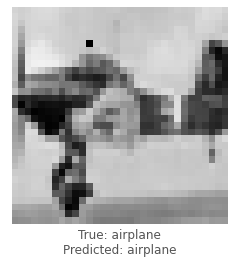

Confidence: 0.9998925
Confidence: 0.9997408
Confidence: 0.9997408
Confidence: 0.9997408
Confidence: 0.9997408
Confidence: 0.99933124
Confidence: 0.99918014
Confidence: 0.99918014
Confidence: 0.9987753
Confidence: 0.9987753
Confidence: 0.9984126
Confidence: 0.9981451
Confidence: 0.9981451
Confidence: 0.9981451
Confidence: 0.9981451
Confidence: 0.99802893
Confidence: 0.99802893
Confidence: 0.99802893
Confidence: 0.99802893
Confidence: 0.99802893
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978764
Confidence: 0.9978694
Confidence: 0.9978694
Confidence: 0.99783057
Confidence: 0.99783057
Confidence: 0.9978248
Confidence: 0.9978248
Confidence: 0.9978248
Confidence: 0.9978248
Confidence: 0.9978248
Confidence: 0.9978248
Confidence: 0.9978248


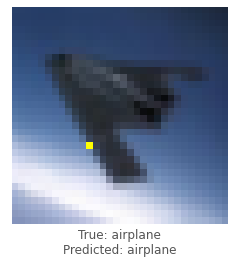

Confidence: 0.9119631
Confidence: 0.849493
Confidence: 0.8139603
Confidence: 0.60395336
Confidence: 0.42255706


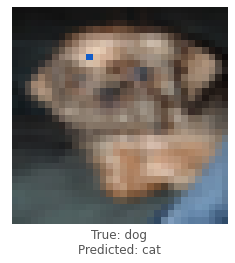

Confidence: 0.99954635
Confidence: 0.9994031
Confidence: 0.9994031
Confidence: 0.99932957
Confidence: 0.99932957
Confidence: 0.99932957
Confidence: 0.9982097
Confidence: 0.9982097
Confidence: 0.9982097
Confidence: 0.99765897
Confidence: 0.99765897
Confidence: 0.99765897
Confidence: 0.99604046
Confidence: 0.99604046
Confidence: 0.99604046
Confidence: 0.99604046
Confidence: 0.99604046
Confidence: 0.9957137
Confidence: 0.9957137
Confidence: 0.9956736
Confidence: 0.9956736
Confidence: 0.9950088
Confidence: 0.9950088
Confidence: 0.9950088
Confidence: 0.9949085
Confidence: 0.9949085
Confidence: 0.9949085
Confidence: 0.9949032
Confidence: 0.9949032
Confidence: 0.9949032
Confidence: 0.9949032
Confidence: 0.9948456
Confidence: 0.9948456
Confidence: 0.9948456
Confidence: 0.9948456
Confidence: 0.99484164
Confidence: 0.99484164
Confidence: 0.99484164
Confidence: 0.99484164
Confidence: 0.99484164
Confidence: 0.99484164
Confidence: 0.99484164
Confidence: 0.99484164
Confidence: 0.99484164
Confidence:

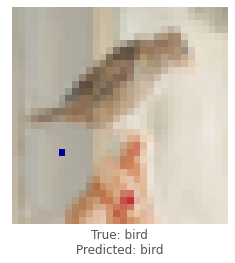

Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confiden

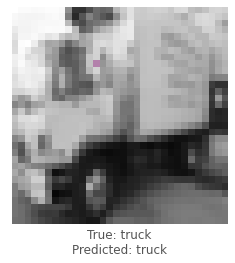

Confidence: 0.0012849427


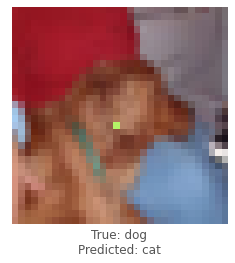

Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999888
Confidence: 0.999987
Confidence: 0.99998474
Confidence: 0.9999796
Confidence: 0.9999796
Confidence: 0.9999796
Confidence: 0.9999796
Confidence: 0.9999796
Confidence: 0.9999796
Confidence: 0.9999796
Confidence: 0.9999796
Confidence: 0.9999796
Confidence: 0.9999796
Confidence: 0.9999796
Confidence: 0.99997807
Confidence: 0.99997807
Confidence: 0.99997747
Confidence: 0.99997747
Confidence: 0.99997616
Confidence: 0.99997616
Confidence: 0.99997616
Confidence: 0.99997616
Confidence: 0.99997616
Confidence: 0.99997616
Confidence: 0.99997616
Confidence: 0.99997616
Confidence: 0.9999757
Confidence: 0.9999757
Confidence: 0.9999757
Confidence: 0.9999757
Confidence: 0.99997544
Confidence: 0.99997544
Confidence: 0.99997544
Confidence: 0.9999753
Confidence: 0.9999753
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.9999751
Confidence: 0.999

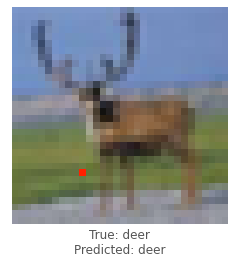

Confidence: 0.007959577


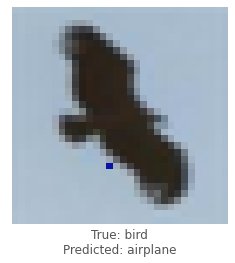

Confidence: 0.99994564
Confidence: 0.99975973
Confidence: 0.9994722
Confidence: 0.9994722
Confidence: 0.9991161
Confidence: 0.9991161
Confidence: 0.9991161
Confidence: 0.99838233
Confidence: 0.99820065
Confidence: 0.99820065
Confidence: 0.99820065
Confidence: 0.99820065
Confidence: 0.99820065
Confidence: 0.99820065
Confidence: 0.99820065
Confidence: 0.99815875
Confidence: 0.99815875
Confidence: 0.99815875
Confidence: 0.9980793
Confidence: 0.9980793
Confidence: 0.9980793
Confidence: 0.9980793
Confidence: 0.9980453
Confidence: 0.9980453
Confidence: 0.9980453
Confidence: 0.9980453
Confidence: 0.9980453
Confidence: 0.9980453
Confidence: 0.99801576
Confidence: 0.99801576
Confidence: 0.99800485
Confidence: 0.997938
Confidence: 0.9979151
Confidence: 0.9979151
Confidence: 0.99790287
Confidence: 0.99790287
Confidence: 0.9979019
Confidence: 0.99788934
Confidence: 0.99788934
Confidence: 0.9978775
Confidence: 0.9978775
Confidence: 0.9978377
Confidence: 0.9978377
Confidence: 0.9978377
Confidence: 0

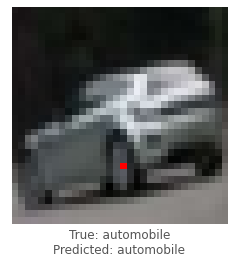

Confidence: 0.6382543
Confidence: 0.5064537
Confidence: 0.5064537
Confidence: 0.48146543


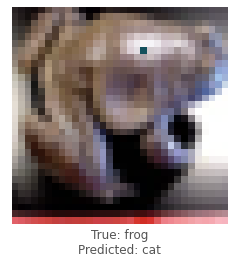

Confidence: 0.9999887
Confidence: 0.99998724
Confidence: 0.99997234
Confidence: 0.9999192
Confidence: 0.9999192
Confidence: 0.9999192
Confidence: 0.9999192
Confidence: 0.9999192
Confidence: 0.99989295
Confidence: 0.99979216
Confidence: 0.99979216
Confidence: 0.99979216
Confidence: 0.99662894
Confidence: 0.9915175
Confidence: 0.9915175
Confidence: 0.9915175
Confidence: 0.9915175
Confidence: 0.9915175
Confidence: 0.9915175
Confidence: 0.9915175
Confidence: 0.9875732
Confidence: 0.9875732
Confidence: 0.9810018
Confidence: 0.9810018
Confidence: 0.9796546
Confidence: 0.9796546
Confidence: 0.9796546
Confidence: 0.977114
Confidence: 0.97704655
Confidence: 0.97704655
Confidence: 0.97704655
Confidence: 0.97704655
Confidence: 0.9725919
Confidence: 0.9725919
Confidence: 0.9725919
Confidence: 0.9716655
Confidence: 0.9716655
Confidence: 0.9716655
Confidence: 0.9716655
Confidence: 0.97151065
Confidence: 0.97151065
Confidence: 0.97151065
Confidence: 0.9713614
Confidence: 0.9713614
Confidence: 0.97123

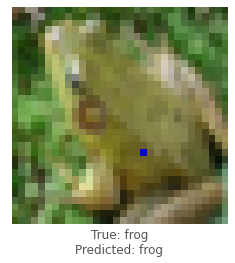

Confidence: 4.013789e-06


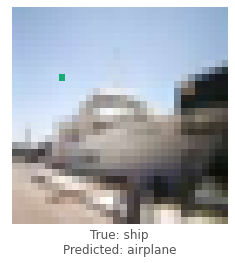

Confidence: 0.9226881
Confidence: 0.9101343
Confidence: 0.8884366
Confidence: 0.8884366
Confidence: 0.8465137
Confidence: 0.8465137
Confidence: 0.73825073
Confidence: 0.73825073
Confidence: 0.73825073
Confidence: 0.73825073
Confidence: 0.73825073
Confidence: 0.73825073
Confidence: 0.73825073
Confidence: 0.73825073
Confidence: 0.73825073
Confidence: 0.73825073
Confidence: 0.7277482
Confidence: 0.7277482
Confidence: 0.7263059
Confidence: 0.7263059
Confidence: 0.7248338
Confidence: 0.7248338
Confidence: 0.7244643
Confidence: 0.7224033
Confidence: 0.7224033
Confidence: 0.72215563
Confidence: 0.72215563
Confidence: 0.72215563
Confidence: 0.72215563
Confidence: 0.72215563
Confidence: 0.72215563
Confidence: 0.7217864
Confidence: 0.7217864
Confidence: 0.7217864
Confidence: 0.72171193
Confidence: 0.72171193
Confidence: 0.72171193
Confidence: 0.72171193
Confidence: 0.72171193
Confidence: 0.72171193
Confidence: 0.72171193
Confidence: 0.72171193
Confidence: 0.72171193
Confidence: 0.72171193
Confid

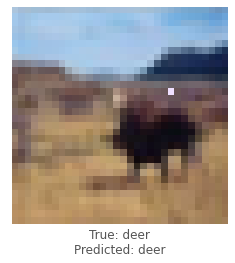

Confidence: 0.29408556


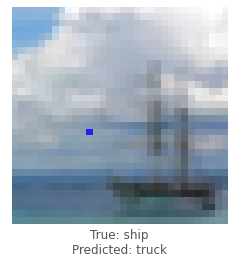

Confidence: 0.940491
Confidence: 0.8502231
Confidence: 0.49763298
Confidence: 0.49763298
Confidence: 0.49763298
Confidence: 0.40926585
Confidence: 0.084899634


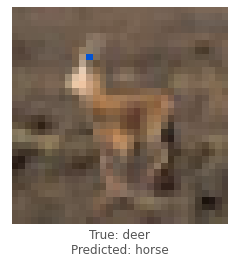

Confidence: 0.989027
Confidence: 0.9867966
Confidence: 0.9867966
Confidence: 0.9867047
Confidence: 0.9867047
Confidence: 0.9867047
Confidence: 0.9867047
Confidence: 0.9796047
Confidence: 0.97919595
Confidence: 0.97919595
Confidence: 0.97823083
Confidence: 0.97756857
Confidence: 0.97756857
Confidence: 0.97756857
Confidence: 0.97756857
Confidence: 0.97756857
Confidence: 0.9767395
Confidence: 0.97419804
Confidence: 0.97137016
Confidence: 0.9708018
Confidence: 0.9708018
Confidence: 0.9708018
Confidence: 0.9708018
Confidence: 0.9706313
Confidence: 0.9706313
Confidence: 0.9706313
Confidence: 0.9706313
Confidence: 0.9706313
Confidence: 0.9706313
Confidence: 0.9706313
Confidence: 0.9706016
Confidence: 0.9704817
Confidence: 0.9704176
Confidence: 0.97038
Confidence: 0.97038
Confidence: 0.97032386
Confidence: 0.97032386
Confidence: 0.97032386
Confidence: 0.97032386
Confidence: 0.97032386
Confidence: 0.9702988
Confidence: 0.9702988
Confidence: 0.9702955
Confidence: 0.9702955
Confidence: 0.9702955


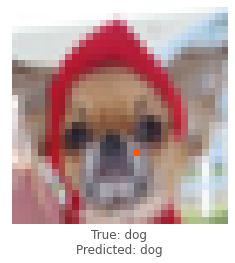

Confidence: 0.0019243301


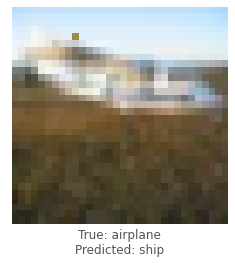

Confidence: 0.9995191
Confidence: 0.9995191
Confidence: 0.9995191
Confidence: 0.9993449
Confidence: 0.9993449
Confidence: 0.9993449
Confidence: 0.9993449
Confidence: 0.9992061
Confidence: 0.9992061
Confidence: 0.9992061
Confidence: 0.9992061
Confidence: 0.9992061
Confidence: 0.9991812
Confidence: 0.9991053
Confidence: 0.9991053
Confidence: 0.99909914
Confidence: 0.99909914
Confidence: 0.99909914
Confidence: 0.9990748
Confidence: 0.9990729
Confidence: 0.9990729
Confidence: 0.9990729
Confidence: 0.9990627
Confidence: 0.9990627
Confidence: 0.9990627
Confidence: 0.9990627
Confidence: 0.9990619
Confidence: 0.9990619
Confidence: 0.9990619
Confidence: 0.9990606
Confidence: 0.9990606
Confidence: 0.9990606
Confidence: 0.9990606
Confidence: 0.9990606
Confidence: 0.99906
Confidence: 0.99906
Confidence: 0.99906
Confidence: 0.99906
Confidence: 0.99906
Confidence: 0.99906
Confidence: 0.99906
Confidence: 0.99906
Confidence: 0.99906
Confidence: 0.99906
Confidence: 0.99906
Confidence: 0.99906
Confidenc

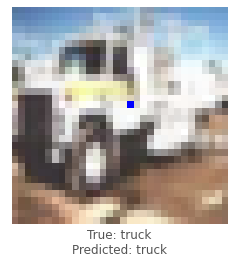

Confidence: 0.021097815


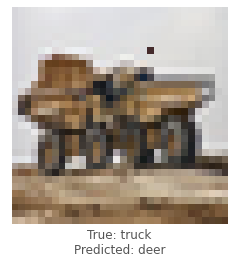

Confidence: 0.9999999
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.9999995
Confidence: 0.9999995
Confidence: 0.9999995
Confidence: 0.9999995
Confidence: 0.9999995
Confidence: 0.9999995
Confidence: 0.9999995
Confidence: 0.99999917
Confidence: 0.99999917
Confidence: 0.99999917
Confidence: 0.99999917
Confidence: 0.99999917
Confidence: 0.99999917
Confidence: 0.99999917
Confidence: 0.99999917
Confidence: 0.99999917
Confidence: 0.99999917
Confidence: 0.99999917
Confidence: 0.99999917
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999905
Confidence: 0.99999

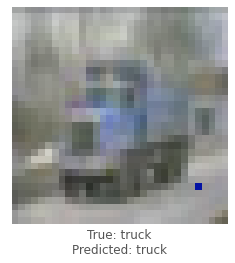

Confidence: 0.8045113
Confidence: 0.8045113
Confidence: 0.8045113
Confidence: 0.8045113
Confidence: 0.7820118
Confidence: 0.7820118
Confidence: 0.75635475
Confidence: 0.746694
Confidence: 0.7042384
Confidence: 0.7042384
Confidence: 0.69435495
Confidence: 0.69435495
Confidence: 0.681013
Confidence: 0.681013
Confidence: 0.681013
Confidence: 0.6748838
Confidence: 0.6736147
Confidence: 0.6736147
Confidence: 0.671003
Confidence: 0.66767454
Confidence: 0.66767454
Confidence: 0.66767454
Confidence: 0.66767454
Confidence: 0.66541445
Confidence: 0.66541445
Confidence: 0.6640607
Confidence: 0.6608954
Confidence: 0.6608954
Confidence: 0.6608954
Confidence: 0.6608954
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.65904313
Confidence: 0.

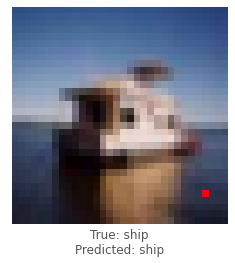

Confidence: 0.9361269
Confidence: 0.9361269
Confidence: 0.9361269
Confidence: 0.9361269
Confidence: 0.91918015
Confidence: 0.9167593
Confidence: 0.9167593
Confidence: 0.9142842
Confidence: 0.9041761
Confidence: 0.9041761
Confidence: 0.9041761
Confidence: 0.89803684
Confidence: 0.8949688
Confidence: 0.8949688
Confidence: 0.89249766
Confidence: 0.891187
Confidence: 0.891187
Confidence: 0.891187
Confidence: 0.88929963
Confidence: 0.889286
Confidence: 0.889286
Confidence: 0.889286
Confidence: 0.889286
Confidence: 0.889286
Confidence: 0.8892164
Confidence: 0.88882416
Confidence: 0.88882416
Confidence: 0.88882416
Confidence: 0.8885467
Confidence: 0.8877111
Confidence: 0.8877111
Confidence: 0.8877111
Confidence: 0.8877111
Confidence: 0.88706255
Confidence: 0.88706255
Confidence: 0.88706255
Confidence: 0.88706255
Confidence: 0.88706255
Confidence: 0.88706255
Confidence: 0.88706255
Confidence: 0.88706255
Confidence: 0.88683474
Confidence: 0.88683474
Confidence: 0.88683474
Confidence: 0.88683474

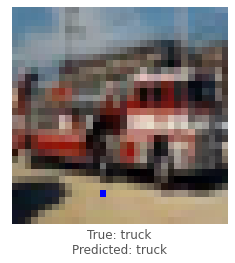

Confidence: 0.999992
Confidence: 0.999992
Confidence: 0.999992
Confidence: 0.999992
Confidence: 0.999992
Confidence: 0.999992
Confidence: 0.9999913
Confidence: 0.9999913
Confidence: 0.9999895
Confidence: 0.9999881
Confidence: 0.99998736
Confidence: 0.99998736
Confidence: 0.99998736
Confidence: 0.99998736
Confidence: 0.99998736
Confidence: 0.99998736
Confidence: 0.99998736
Confidence: 0.99998736
Confidence: 0.99998736
Confidence: 0.99998736
Confidence: 0.99998736
Confidence: 0.99998724
Confidence: 0.99998724
Confidence: 0.99998724
Confidence: 0.99998724
Confidence: 0.99998724
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871
Confidence: 0.9999871


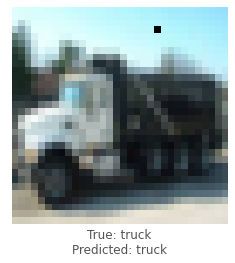

Confidence: 0.3966085


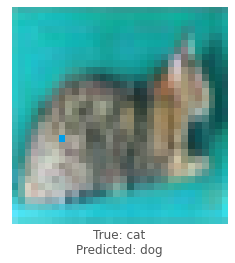

Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confiden

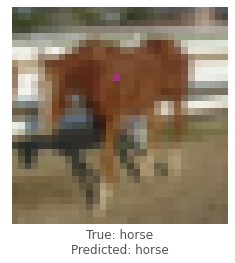

Confidence: 3.830684e-05


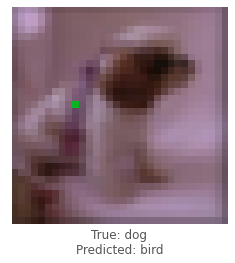

Confidence: 0.99983656
Confidence: 0.9993174
Confidence: 0.9991972
Confidence: 0.9991972
Confidence: 0.9990171
Confidence: 0.9990171
Confidence: 0.9990171
Confidence: 0.9990171
Confidence: 0.9990171
Confidence: 0.9990031
Confidence: 0.9990031
Confidence: 0.9990031
Confidence: 0.9990031
Confidence: 0.9990031
Confidence: 0.998993
Confidence: 0.998993
Confidence: 0.99898475
Confidence: 0.99897337
Confidence: 0.9989507
Confidence: 0.9989507
Confidence: 0.9989507
Confidence: 0.9989473
Confidence: 0.9989473
Confidence: 0.9989472
Confidence: 0.9989409
Confidence: 0.9989409
Confidence: 0.99894077
Confidence: 0.99894077
Confidence: 0.99894077
Confidence: 0.9989392
Confidence: 0.9989392
Confidence: 0.9989392
Confidence: 0.9989392
Confidence: 0.9989392
Confidence: 0.9989392
Confidence: 0.9989392
Confidence: 0.9989392
Confidence: 0.9989392
Confidence: 0.9989384
Confidence: 0.9989384
Confidence: 0.9989384
Confidence: 0.9989384
Confidence: 0.9989384
Confidence: 0.9989384
Confidence: 0.9989384
Confid

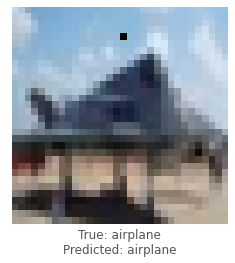

Confidence: 0.146076


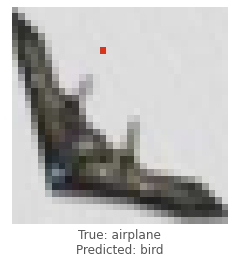

Confidence: 0.99937254
Confidence: 0.99937254
Confidence: 0.99847203
Confidence: 0.99847203
Confidence: 0.99847203
Confidence: 0.9971431
Confidence: 0.9945457
Confidence: 0.9945457
Confidence: 0.9934557
Confidence: 0.99228984
Confidence: 0.99228984
Confidence: 0.99228984
Confidence: 0.9922327
Confidence: 0.9922327
Confidence: 0.9922327
Confidence: 0.9922327
Confidence: 0.9922327
Confidence: 0.9922327
Confidence: 0.9922126
Confidence: 0.9922126
Confidence: 0.9919566
Confidence: 0.9919566
Confidence: 0.9919566
Confidence: 0.9919566
Confidence: 0.9919566
Confidence: 0.9919486
Confidence: 0.9919486
Confidence: 0.9919457
Confidence: 0.99194264
Confidence: 0.99194264
Confidence: 0.9919389
Confidence: 0.9919389
Confidence: 0.9919389
Confidence: 0.9919376
Confidence: 0.9919376
Confidence: 0.9919376
Confidence: 0.9919376
Confidence: 0.9919376
Confidence: 0.9919376
Confidence: 0.9919376
Confidence: 0.9919376
Confidence: 0.9919376
Confidence: 0.9919376
Confidence: 0.9919376
Confidence: 0.9919376


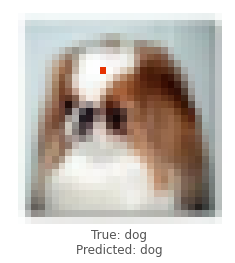

Confidence: 0.99999964
Confidence: 0.99999833
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999957
Confidence: 0.9999957
Confidence: 0.9999957
Confidence: 0.9999957
Confidence: 0.9999957
Confidence: 0.9999957
Confidence: 0.9999957
Confidence: 0.9999957
Confidence: 0.9999957
Confidence: 0.9999956
Confidence: 0.9999956
Confidence: 0.9999956
Confidence: 0.9999956
Confidence: 0.9999956
Confidence: 0.9999956
Confidence: 0.9999956
Confidence: 0.9999956
Confidence: 0.9999956
Confiden

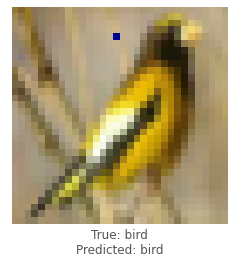

Confidence: 0.64679474
Confidence: 0.64679474
Confidence: 0.64679474
Confidence: 0.64679474
Confidence: 0.61881644
Confidence: 0.61881644
Confidence: 0.61881644
Confidence: 0.61881644
Confidence: 0.61881644
Confidence: 0.52174854
Confidence: 0.4507996


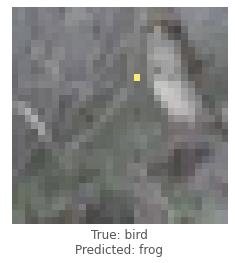

Confidence: 0.99981683
Confidence: 0.99933726
Confidence: 0.99916875
Confidence: 0.99881786
Confidence: 0.9985721
Confidence: 0.99852353
Confidence: 0.99834883
Confidence: 0.9979571
Confidence: 0.9979571
Confidence: 0.9979571
Confidence: 0.9979571
Confidence: 0.99772936
Confidence: 0.9973334
Confidence: 0.9973334
Confidence: 0.9973334
Confidence: 0.9972362
Confidence: 0.9970835
Confidence: 0.99696004
Confidence: 0.99696004
Confidence: 0.9968002
Confidence: 0.9968002
Confidence: 0.9968002
Confidence: 0.99679285
Confidence: 0.99679285
Confidence: 0.99679285
Confidence: 0.99677485
Confidence: 0.99677485
Confidence: 0.99677485
Confidence: 0.99677485
Confidence: 0.99677485
Confidence: 0.9967687
Confidence: 0.9967687
Confidence: 0.9967687
Confidence: 0.9967687
Confidence: 0.9967687
Confidence: 0.9967687
Confidence: 0.99676764
Confidence: 0.99676764
Confidence: 0.99676764
Confidence: 0.99676764
Confidence: 0.99676764
Confidence: 0.99676764
Confidence: 0.99676764
Confidence: 0.99676764
Confide

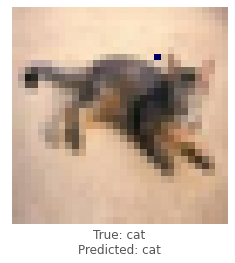

Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confidence: 1.0
Confiden

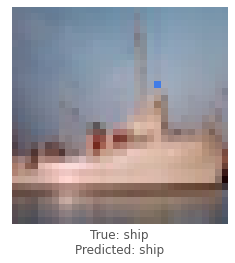

Confidence: 0.9999871
Confidence: 0.999951
Confidence: 0.999951
Confidence: 0.999951
Confidence: 0.999951
Confidence: 0.999951
Confidence: 0.999951
Confidence: 0.9999367
Confidence: 0.9999367
Confidence: 0.9999367
Confidence: 0.9999201
Confidence: 0.9999201
Confidence: 0.999814
Confidence: 0.999814
Confidence: 0.999814
Confidence: 0.999814
Confidence: 0.999814
Confidence: 0.999814
Confidence: 0.999814
Confidence: 0.999814
Confidence: 0.999814
Confidence: 0.999814
Confidence: 0.9997975
Confidence: 0.9997948
Confidence: 0.9997948
Confidence: 0.9997948
Confidence: 0.9997948
Confidence: 0.99972826
Confidence: 0.99972826
Confidence: 0.99970216
Confidence: 0.9996917
Confidence: 0.9996917
Confidence: 0.9996917
Confidence: 0.9996917
Confidence: 0.9996898
Confidence: 0.9996898
Confidence: 0.99968886
Confidence: 0.99968886
Confidence: 0.9996712
Confidence: 0.9996712
Confidence: 0.9996712
Confidence: 0.99967074
Confidence: 0.9996692
Confidence: 0.9996692
Confidence: 0.9996692
Confidence: 0.999669

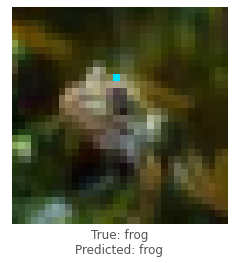

Confidence: 0.53528464
Confidence: 0.40927282


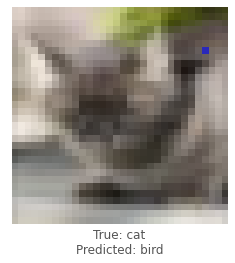

Confidence: 0.014160361


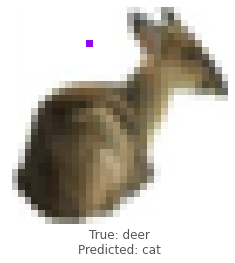

Confidence: 0.9999329
Confidence: 0.99830985
Confidence: 0.9974595
Confidence: 0.9974595
Confidence: 0.996188
Confidence: 0.996188
Confidence: 0.99295855
Confidence: 0.9929525
Confidence: 0.9929525
Confidence: 0.98998743
Confidence: 0.9869306
Confidence: 0.9869306
Confidence: 0.98532176
Confidence: 0.9847135
Confidence: 0.9847135
Confidence: 0.9847135
Confidence: 0.9847135
Confidence: 0.9847135
Confidence: 0.9847135
Confidence: 0.9847135
Confidence: 0.9847135
Confidence: 0.9842116
Confidence: 0.9842116
Confidence: 0.98411894
Confidence: 0.98411894
Confidence: 0.98411894
Confidence: 0.9840406
Confidence: 0.9840406
Confidence: 0.9840406
Confidence: 0.9840406
Confidence: 0.9840406
Confidence: 0.984
Confidence: 0.984
Confidence: 0.9839139
Confidence: 0.98383766
Confidence: 0.98383766
Confidence: 0.98380566
Confidence: 0.98380566
Confidence: 0.98380566
Confidence: 0.98379505
Confidence: 0.98379505
Confidence: 0.98379505
Confidence: 0.98379505
Confidence: 0.98379505
Confidence: 0.98379505
Co

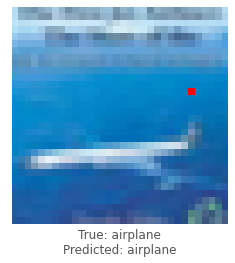

Confidence: 0.9976616
Confidence: 0.9975701
Confidence: 0.9975701
Confidence: 0.9975701
Confidence: 0.9975701
Confidence: 0.9970626
Confidence: 0.9969061
Confidence: 0.99663997
Confidence: 0.99658644
Confidence: 0.99658644
Confidence: 0.99658644
Confidence: 0.99658644
Confidence: 0.99658644
Confidence: 0.99658644
Confidence: 0.9965599
Confidence: 0.9965599
Confidence: 0.996525
Confidence: 0.99614847
Confidence: 0.99614847
Confidence: 0.9961414
Confidence: 0.9961414
Confidence: 0.99610424
Confidence: 0.9960867
Confidence: 0.9960373
Confidence: 0.99600875
Confidence: 0.99600345
Confidence: 0.99600345
Confidence: 0.9959512
Confidence: 0.99594456
Confidence: 0.99594456
Confidence: 0.99594456
Confidence: 0.9959363
Confidence: 0.9959363
Confidence: 0.9959363
Confidence: 0.9959363
Confidence: 0.9959363
Confidence: 0.9959363
Confidence: 0.9959363
Confidence: 0.9959363
Confidence: 0.9959363
Confidence: 0.9959363
Confidence: 0.9959351
Confidence: 0.9959351
Confidence: 0.9959351
Confidence: 0.995

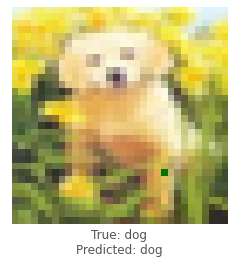

Confidence: 0.999602
Confidence: 0.9995877
Confidence: 0.9994991
Confidence: 0.9994991
Confidence: 0.9994991
Confidence: 0.9994991
Confidence: 0.9994991
Confidence: 0.9994991
Confidence: 0.9994991
Confidence: 0.99948823
Confidence: 0.99921453
Confidence: 0.99921453
Confidence: 0.99765176
Confidence: 0.99765176
Confidence: 0.99765176
Confidence: 0.99765176
Confidence: 0.99765176
Confidence: 0.99765176
Confidence: 0.99765176
Confidence: 0.99707484
Confidence: 0.9966723
Confidence: 0.9964144
Confidence: 0.9964144
Confidence: 0.9964144
Confidence: 0.9964144
Confidence: 0.9964144
Confidence: 0.9964144
Confidence: 0.99628145
Confidence: 0.99628145
Confidence: 0.99628145
Confidence: 0.99589574
Confidence: 0.99589574
Confidence: 0.99589574
Confidence: 0.99588805
Confidence: 0.99588805
Confidence: 0.99588805
Confidence: 0.99588805
Confidence: 0.99588805
Confidence: 0.9955029
Confidence: 0.9955029
Confidence: 0.99543226
Confidence: 0.99543226
Confidence: 0.9953999
Confidence: 0.9953999
Confidenc

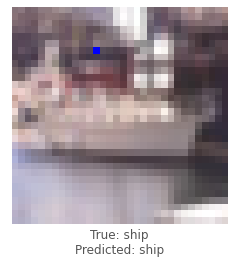

Confidence: 0.09929749


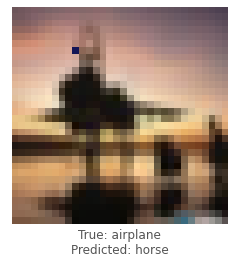

Confidence: 0.9988576
Confidence: 0.99881965
Confidence: 0.99881965
Confidence: 0.99727374
Confidence: 0.99604994
Confidence: 0.99604994
Confidence: 0.9960187
Confidence: 0.9960187
Confidence: 0.9960187
Confidence: 0.9956039
Confidence: 0.9956039
Confidence: 0.9956039
Confidence: 0.9948886
Confidence: 0.9948886
Confidence: 0.9948886
Confidence: 0.9941116
Confidence: 0.9941116
Confidence: 0.9941116
Confidence: 0.9940811
Confidence: 0.99396884
Confidence: 0.99396884
Confidence: 0.9937888
Confidence: 0.9935222
Confidence: 0.9935222
Confidence: 0.9935222
Confidence: 0.9935222
Confidence: 0.9935108
Confidence: 0.9935108
Confidence: 0.99349964
Confidence: 0.99349964
Confidence: 0.99349964
Confidence: 0.99349964
Confidence: 0.99349964
Confidence: 0.99349964
Confidence: 0.99349964
Confidence: 0.99349385
Confidence: 0.99347407
Confidence: 0.99347407
Confidence: 0.99346995
Confidence: 0.99346983
Confidence: 0.99346983
Confidence: 0.99346983
Confidence: 0.99346876
Confidence: 0.99346876
Confidenc

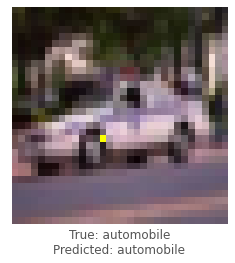

Confidence: 0.9999987
Confidence: 0.9999987
Confidence: 0.9999987
Confidence: 0.99999857
Confidence: 0.99999654
Confidence: 0.99999225
Confidence: 0.99999225
Confidence: 0.99999225
Confidence: 0.99999225
Confidence: 0.99999225
Confidence: 0.99999166
Confidence: 0.99999166
Confidence: 0.99999166
Confidence: 0.9999913
Confidence: 0.9999913
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999906
Confidence: 0.99999046
Confidence: 0.99999046
Confidence: 0.9999902
Confidence: 0.9999902
Confidence: 0.9999902
Confidence: 0.9999902
Confidence: 0.9999902
Confidence: 0.9999902
Confidence: 0.9999902
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.9999901
Confidence: 0.99999
Confidence: 0.99999
Confidence: 0.99999
Confidence: 0.99999
Confidence: 0.99999
Confidence: 0.99999
Confidence

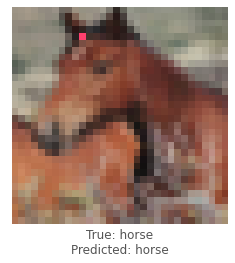

Confidence: 0.005586656


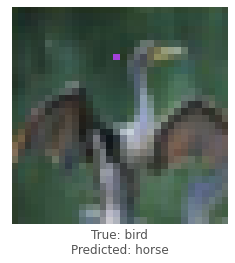

Confidence: 0.9998211
Confidence: 0.9998211
Confidence: 0.9998211
Confidence: 0.9998211
Confidence: 0.9998211
Confidence: 0.9998211
Confidence: 0.9998211
Confidence: 0.9996426
Confidence: 0.9996426
Confidence: 0.9996426
Confidence: 0.99959475
Confidence: 0.9995358
Confidence: 0.9992705
Confidence: 0.9992705
Confidence: 0.99926764
Confidence: 0.99926764
Confidence: 0.99926764
Confidence: 0.9991948
Confidence: 0.99907935
Confidence: 0.999015
Confidence: 0.999015
Confidence: 0.999015
Confidence: 0.999015
Confidence: 0.999015
Confidence: 0.999015
Confidence: 0.999015
Confidence: 0.999015
Confidence: 0.999015
Confidence: 0.999015
Confidence: 0.999015
Confidence: 0.999015
Confidence: 0.999015
Confidence: 0.99900657
Confidence: 0.99900657
Confidence: 0.99900657
Confidence: 0.99900657
Confidence: 0.99900657
Confidence: 0.99900657
Confidence: 0.99900657
Confidence: 0.99900657
Confidence: 0.99900657
Confidence: 0.99900657
Confidence: 0.99900657
Confidence: 0.99900657
Confidence: 0.99900657
Confi

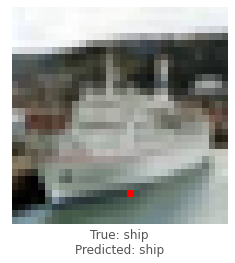

Confidence: 0.8928987
Confidence: 0.8217394
Confidence: 0.8217394
Confidence: 0.8217394
Confidence: 0.8217394
Confidence: 0.8217394
Confidence: 0.8171527
Confidence: 0.55396265
Confidence: 0.55396265
Confidence: 0.551263
Confidence: 0.551263
Confidence: 0.4676867


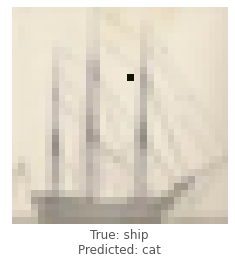

Confidence: 0.9994954
Confidence: 0.9994954
Confidence: 0.99868745
Confidence: 0.99815375
Confidence: 0.99815375
Confidence: 0.99815375
Confidence: 0.99815375
Confidence: 0.99815375
Confidence: 0.99797136
Confidence: 0.99728525
Confidence: 0.99728525
Confidence: 0.99723047
Confidence: 0.99718213
Confidence: 0.9966822
Confidence: 0.9966227
Confidence: 0.9966227
Confidence: 0.9966227
Confidence: 0.9966227
Confidence: 0.9966227
Confidence: 0.996539
Confidence: 0.9964217
Confidence: 0.9964217
Confidence: 0.9963973
Confidence: 0.9963973
Confidence: 0.9963973
Confidence: 0.9963973
Confidence: 0.9963973
Confidence: 0.9963973
Confidence: 0.99636567
Confidence: 0.99636567
Confidence: 0.99636567
Confidence: 0.99636567
Confidence: 0.99636567
Confidence: 0.99636567
Confidence: 0.99636567
Confidence: 0.99636567
Confidence: 0.99636567
Confidence: 0.99636567
Confidence: 0.9963559
Confidence: 0.9963559
Confidence: 0.9963559
Confidence: 0.99634534
Confidence: 0.99634534
Confidence: 0.99634534
Confidenc

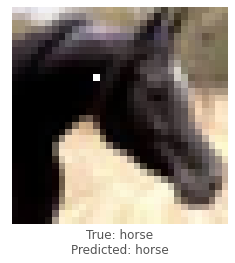

Confidence: 0.9999989
Confidence: 0.9999989
Confidence: 0.9999989
Confidence: 0.9999989
Confidence: 0.9999989
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.99999785
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999925
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidence: 0.9999924
Confidenc

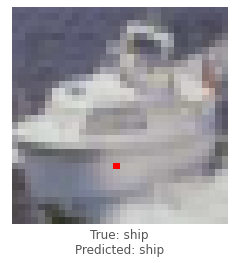

Confidence: 0.010214686


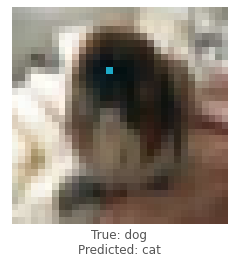

Confidence: 0.8059401
Confidence: 0.8059401
Confidence: 0.702168
Confidence: 0.702168
Confidence: 0.63397354
Confidence: 0.40387467


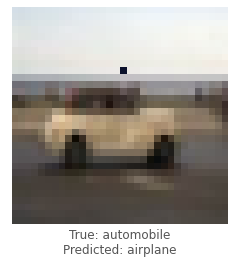

ValueError: ignored

In [ ]:
image_id = 102
pixels = 1 # Number of pixels to attack
model = resnet
pic = []
label = []
for num in range(0,100):
  attack_image = attack(image_id+num, model, pixel_count=pixels, verbose=True)
  pic.append(attack_image[0])
  labelarr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  labelarr[attack_image[1]] = 1
  label.append(labelarr)

this_test_x = np.array(pic)
this_test_y = np.array(label)






In [ ]:
from google.colab import files
import pandas as pd
print(this_test_x.shape)
this_data = this_test_x.reshape(100, 32*32*3)
df_data = pd.DataFrame(this_data)
df_data.to_csv('data.csv')
files.download("data.csv")
print(this_test_y.shape)

df_label = pd.DataFrame(this_test_y)
df_label.to_csv('label.csv')
files.download("label.csv")

(100, 32, 32, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(100, 10)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>